In [27]:
!pip install sklearn-crfsuite
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

https://www.kaggle.com/code/naseralqaydeh/named-entity-recognition-ner-with-tensorflow


https://www.kaggle.com/competitions/coleridgeinitiative-show-us-the-data/discussion/228376

In [29]:
#from google.colab import drive
#drive.mount('/content/drive')

In [30]:
!pip list --format=freeze > requirements.txt

In [31]:
df = pd.read_csv("/content/drive/MyDrive/ATC_DATA/BIO-Annotations-1.csv")
#df = df.fillna(method='ffill')
df.head(10)

,sentence,Words,Tag
0,1,us,B-callsign
1,1,air,I-callsign
2,1,two,I-callsign
3,1,thirty,I-callsign
4,1,seven,o
5,1,washington,I-frequency1
6,1,departure,B-frequency1
7,1,radar,I-frequency1
8,1,contact,I-frequency1
9,1,climb,B-level1


In [32]:
df.isnull().sum()

sentence    0
Words       0
Tag         0
dtype: int64

In [33]:
words = list(set(df['Words'].values))
num_words = len(words)
tags = list(set(df['Tag'].values))#iob2 tags 
num_tags = len(tags)
num_words, num_tags

(1173, 17)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114047 entries, 0 to 114046
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   sentence  114047 non-null  int64 
 1   Words     114047 non-null  object
 2   Tag       114047 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.6+ MB


In [35]:
# Retrive sentences and tags from the dataset
class SentenceGetter(object):
        
        def __init__(self, data):
            self.n_sent = 1
            self.data = data
            self.empty = False
            agg_func = lambda s: [(w, t) for w, t in zip(s["Words"].values.tolist(),
                                                            s["Tag"].values.tolist())]
            self.grouped = self.data.groupby("sentence").apply(agg_func)
            self.sentences = [s for s in self.grouped]

        def get_next(self):
            try:
                s = self.grouped["Sentence: {}".format(self.n_sent)]
                self.n_sent += 1
                return s
            except:
                return None

getter = SentenceGetter(df)
sentences = getter.sentences

In [36]:
getter

In [37]:
sentences

[[('us', 'B-callsign'),
  ('air', 'I-callsign'),
  ('two', 'I-callsign'),
  ('thirty', 'I-callsign'),
  ('seven', 'o'),
  ('washington', 'I-frequency1'),
  ('departure', 'B-frequency1'),
  ('radar', 'I-frequency1'),
  ('contact', 'I-frequency1'),
  ('climb', 'B-level1'),
  ('and', 'I-level1'),
  ('maintain', 'I-level1'),
  ('one', 'o'),
  ('five', 'I-callsign'),
  ('thousand', 'o')],
 [('delta', 'B-callsign'),
  ('two', 'I-callsign'),
  ('oh', 'o'),
  ('nine', 'I-callsign'),
  ('turn', 'B-heading1'),
  ('left', 'I-heading1'),
  ('heading', 'B-heading1'),
  ('two', 'I-callsign'),
  ('four', 'I-callsign'),
  ('zero', 'I-callsign')],
 [('us', 'B-callsign'),
  ('air', 'I-callsign'),
  ('two', 'I-callsign'),
  ('thirty', 'I-callsign'),
  ('seven', 'o'),
  ('turn', 'B-heading1'),
  ('left', 'I-heading1'),
  ('heading', 'B-heading1'),
  ('two', 'I-callsign'),
  ('one', 'o'),
  ('zero', 'I-callsign'),
  ('join', 'B-direct1'),
  ('the', 'o'),
  ('gordonsville', 'o'),
  ('zero', 'I-callsign'),
 

In [38]:
word2idx = {w: i for i, w in enumerate(words)}
print (word2idx)
tag2idx = {t: i for i, t in enumerate(tags)}
print(tag2idx)

{'suggest': 0, 'all': 1, 'road': 2, 'good': 3, 'twenty-two': 4, 'andrews': 5, 'logan': 6, 'upsco': 7, 'if': 8, 'well': 9, 'delta': 10, 'either': 11, 'tighter': 12, 'hold': 13, 'skylane': 14, 'present': 15, 'nantucket': 16, 'air': 17, 'airspeed': 18, 'been': 19, 'though': 20, 'holts': 21, 'jetlink': 22, 'standby': 23, 'few': 24, 'chaparral': 25, 'uniform': 26, 'met': 27, 'can': 28, 'medstar': 29, 'vor': 30, 'gave': 31, 'checking': 32, "seventy's": 33, 'down': 34, 'convective': 35, 'cape': 36, 'yankee': 37, "right's": 38, 'crown': 39, 'cola': 40, 'feasible': 41, 'three': 42, 'jetex': 43, 'possibility': 44, 'expected': 45, 'later': 46, 'hyde': 47, 'meacham': 48, 'conquest': 49, 'x-ray': 50, 'boston': 51, 'saber': 52, 'turning': 53, "metro's": 54, 'national': 55, 'very': 56, 'quebec': 57, "hotel's": 58, "nine's": 59, 'ryan': 60, 'lufthansa': 61, 'forty-three': 62, 'hamak': 63, 'linden': 64, 'northeast': 65, 'dulles': 66, "that'll": 67, 'severe': 68, 'india': 69, 'or': 70, 'minimum': 71, 'w

In [39]:
idx2word = {i: w for w, i in word2idx.items()}
idx2tag = {i: w for w, i in tag2idx.items()}

In [40]:
idx2tag

{0: 'B-traffic1',
 1: 'I-heading1',
 2: 'I-speed1',
 3: 'o',
 4: 'B-level1',
 5: 'I-frequency1',
 6: 'B-direct1',
 7: 'I-traffic2',
 8: 'B-callsign',
 9: 'B-level2',
 10: 'B-heading1',
 11: 'B-frequency1',
 12: 'B-speed1',
 13: 'I-traffic1',
 14: 'I-direct1',
 15: 'I-callsign',
 16: 'I-level1'}

In [41]:
from keras_preprocessing.sequence import pad_sequences#add numbers to the sequences to make them all be the same length. 
from keras.utils import to_categorical

In [42]:
max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences = X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag2idx['o'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [44]:
x_train

array([[1167,  263,  452, ..., 1172, 1172, 1172],
       [ 277,  737,  864, ..., 1172, 1172, 1172],
       [ 694,   17,  851, ..., 1172, 1172, 1172],
       ...,
       [  10,   42,  851, ..., 1172, 1172, 1172],
       [ 445,  907,  864, ..., 1172, 1172, 1172],
       [ 882,  435, 1169, ..., 1172, 1172, 1172]], dtype=int32)

In [45]:
print("Size of training input data : ", x_train.shape)
print("Size of training output data : ", np.array(y_train).shape)
print("Size of testing input data : ", x_test.shape)
print("Size of testing output data : ", np.array(y_test).shape)

Size of training input data :  (5769, 50)
Size of training output data :  (5769, 50, 17)
Size of testing input data :  (2473, 50)
Size of testing output data :  (2473, 50, 17)


In [46]:
# Let's check the first sentence before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[0] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', X[0])

*****Before Processing first sentence : *****
 us air two thirty seven washington departure radar contact climb and maintain one five thousand
*****After Processing first sentence : *****
  [ 694   17  907  851  389  243   97  400 1146  850  471  318  737  791
 1103 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172
 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172 1172
 1172 1172 1172 1172 1172 1172 1172 1172]


In [47]:
# First label before and after processing.
print('*****Before Processing first sentence : *****\n', ' '.join([w[1] for w in sentences[0]]))
print('*****After Processing first sentence : *****\n ', y[0])

*****Before Processing first sentence : *****
 B-callsign I-callsign I-callsign I-callsign o I-frequency1 B-frequency1 I-frequency1 I-frequency1 B-level1 I-level1 I-level1 o I-callsign o
*****After Processing first sentence : *****
  [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0.

In [48]:
from keras import Model, Input
from keras.layers import LSTM, Embedding, Dense,GRU
from keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

#from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle


In [49]:
input_word = Input(shape=(max_len, ))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.2)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.2))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 50)            58650     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 200)          120800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 50, 17)           3417      
 tributed)                                                       
                                                           

In [50]:
import tensorflow as tf


In [51]:
model.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [52]:
import numpy as np
history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 25
    
)

Epoch 1/25
145/145 [==============================] - 70s 456ms/step - loss: 1.5618 - accuracy: 0.8176 - val_loss: 0.5317 - val_accuracy: 0.8471
Epoch 2/25
145/145 [==============================] - 49s 335ms/step - loss: 0.5003 - accuracy: 0.8480 - val_loss: 0.4929 - val_accuracy: 0.8471
Epoch 3/25
145/145 [==============================] - 50s 348ms/step - loss: 0.4781 - accuracy: 0.8480 - val_loss: 0.4754 - val_accuracy: 0.8471
Epoch 4/25
145/145 [==============================] - 48s 333ms/step - loss: 0.4606 - accuracy: 0.8503 - val_loss: 0.4557 - val_accuracy: 0.8534
Epoch 5/25
145/145 [==============================] - 50s 348ms/step - loss: 0.4408 - accuracy: 0.8651 - val_loss: 0.4335 - val_accuracy: 0.8772
Epoch 6/25
145/145 [==============================] - 48s 334ms/step - loss: 0.4156 - accuracy: 0.8845 - val_loss: 0.4032 - val_accuracy: 0.8941
Epoch 7/25
145/145 [==============================] - 48s 332ms/step - loss: 0.3817 - accuracy: 0.9027 - val_loss: 0.3637 - val_ac

In [53]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

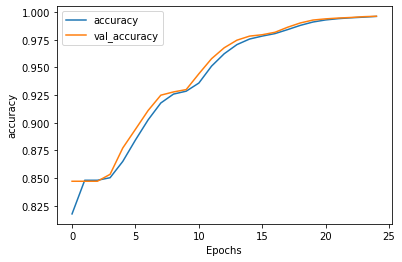

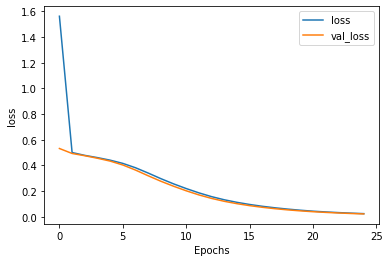

In [54]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [55]:
model.evaluate(x_test, np.array(y_test))

78/78 [==============================] - 3s 35ms/step - loss: 0.0213 - accuracy: 0.9965


[0.021301066502928734, 0.996498167514801]

In [56]:
# Evaluation
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

78/78 [==============================] - 3s 35ms/step


In [57]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [58]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 97.3%


In [59]:
y_pred=y_pred
y_true=y_test_true
from seqeval.metrics import classification_report
report = classification_report(y_true,y_pred,suffix=True, zero_division='warn',
                          scheme=None)
print(report)

              precision    recall  f1-score   support

           B       0.98      0.95      0.97      3895
           I       0.98      0.97      0.98      8370
           _       0.99      0.99      0.99      6576

   micro avg       0.98      0.97      0.98     18841
   macro avg       0.98      0.97      0.98     18841
weighted avg       0.98      0.97      0.98     18841



In [60]:
y_pred=y_pred
y_true=y_test_true
from seqeval.metrics import classification_report
report = classification_report(y_true,y_pred,suffix=True, zero_division='warn',
                          scheme=None)
print(report)

              precision    recall  f1-score   support

           B       0.98      0.95      0.97      3895
           I       0.98      0.97      0.98      8370
           _       0.99      0.99      0.99      6576

   micro avg       0.98      0.97      0.98     18841
   macro avg       0.98      0.97      0.98     18841
weighted avg       0.98      0.97      0.98     18841



In [61]:
new_classes= list(idx2tag.values())
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
m = MultiLabelBinarizer().fit(y_true)
print(classification_report(m.transform(y_true), m.transform(y_pred),target_names=list(m.classes_)))

              precision    recall  f1-score   support

  B-callsign       0.96      0.99      0.97      1493
   B-direct1       0.00      0.00      0.00         4
B-frequency1       1.00      0.94      0.97       301
  B-heading1       1.00      1.00      1.00       921
    B-level1       0.89      0.93      0.91       453
    B-level2       0.00      0.00      0.00         3
    B-speed1       1.00      0.40      0.57       139
  B-traffic1       0.00      0.00      0.00        69
  I-callsign       1.00      1.00      1.00      2432
   I-direct1       0.00      0.00      0.00         5
I-frequency1       1.00      0.99      1.00      1057
  I-heading1       1.00      1.00      1.00       816
    I-level1       1.00      1.00      1.00       969
    I-speed1       0.78      0.87      0.82       303
  I-traffic1       0.00      0.00      0.00         1
  I-traffic2       0.00      0.00      0.00        67
           o       1.00      1.00      1.00      2473

   micro avg       0.98   

In [62]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,x_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, x_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(x_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-1], idx2tag[t], idx2tag[pred]))

1/1 [==============================] - 0s 55ms/step
Sample number 2125 of 2473 (Test Set)
Word           ||True ||Pred
tuffo          : B-callsign B-callsign
nantucket      : I-callsign I-callsign
bos            : I-callsign I-callsign
bandit's       : I-callsign I-callsign
bos            : I-callsign I-callsign
presently      : B-speed1 B-speed1
measured       : I-speed1 I-speed1
sight          : o     o
control        : I-callsign I-callsign
descend-       : o     o
bandit's       : I-callsign I-callsign
f              : o     o
'll            : o     o
last           : I-level1 I-level1
localizer      : I-level1 I-level1
would          : I-callsign I-callsign
turn           : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doing          : o     o
doin

In [63]:
"import pickle"

'import pickle'

In [64]:
"""model.save('/content/drive/My Drive/ner_lstm.h5')

with open('/content/drive/My Drive/NERobjs.pkl', 'wb') as f: 
    pickle.dump([word2idx, words, tags], f)"""

"model.save('/content/drive/My Drive/ner_lstm.h5')\n\nwith open('/content/drive/My Drive/NERobjs.pkl', 'wb') as f: \n    pickle.dump([word2idx, words, tags], f)"

In [65]:
"""from keras.models import load_model
model = load_model("/content/drive/My Drive/ner_lstm.h5")

with open('/content/drive/My Drive/NERobjs.pkl','rb') as f:  
    word2idx, words, tags = pickle.load(f)"""

'from keras.models import load_model\nmodel = load_model("/content/drive/My Drive/ner_lstm.h5")\n\nwith open(\'/content/drive/My Drive/NERobjs.pkl\',\'rb\') as f:  \n    word2idx, words, tags = pickle.load(f)'

In [66]:
"""#import nltk
#nltk.download('punkt')
#from nltk.tokenize import word_tokenize
import re
def make_prediction(sentence):
    sentence = re.sub('[^a-zA-Z0-9]',' ', sentence)
    tokens = sentence.split(" ")
    print(tokens)
    max_len = 50
    num_words = len(tokens)
    X_pred = [[word2idx[w] for w in tokens]]
    X_pred = pad_sequences(maxlen=max_len, sequences=X_pred, padding="post", value=num_words-1)
    p = model.predict(np.array([X_pred[0]]))
    p = np.argmax(p, axis=-1)
    print("{:15}\t{}\n".format("Word", "Pred"))
    print("-"*30)
    tags_pred = []
    token_list =[]
    
    for (w, pred) in zip(X_pred[0][:len(tokens)], p[0][:len(tokens)]):
        print("{:15}\t{}".format(words[w-1], tags[pred]))
        tags_pred.append(tags[pred])
        tags_pred.append('o')
        token_list.append(words[w-1])
        token_list.append(' ')
        
    output_tuple = list(zip(token_list[:-1], tags_pred[:-1]))
    print(output_tuple)
    return output_tuple"""


'#import nltk\n#nltk.download(\'punkt\')\n#from nltk.tokenize import word_tokenize\nimport re\ndef make_prediction(sentence):\n    sentence = re.sub(\'[^a-zA-Z0-9]\',\' \', sentence)\n    tokens = sentence.split(" ")\n    print(tokens)\n    max_len = 50\n    num_words = len(tokens)\n    X_pred = [[word2idx[w] for w in tokens]]\n    X_pred = pad_sequences(maxlen=max_len, sequences=X_pred, padding="post", value=num_words-1)\n    p = model.predict(np.array([X_pred[0]]))\n    p = np.argmax(p, axis=-1)\n    print("{:15}\t{}\n".format("Word", "Pred"))\n    print("-"*30)\n    tags_pred = []\n    token_list =[]\n    \n    for (w, pred) in zip(X_pred[0][:len(tokens)], p[0][:len(tokens)]):\n        print("{:15}\t{}".format(words[w-1], tags[pred]))\n        tags_pred.append(tags[pred])\n        tags_pred.append(\'o\')\n        token_list.append(words[w-1])\n        token_list.append(\' \')\n        \n    output_tuple = list(zip(token_list[:-1], tags_pred[:-1]))\n    print(output_tuple)\n    retur

In [67]:
"""X_pred = make_prediction("us air two thirty seven climb and maintain flight level two one zero")
X_pred"""

'X_pred = make_prediction("us air two thirty seven climb and maintain flight level two one zero")\nX_pred'

In [68]:
"""colormap = {'B-callsign': 'magenta',
 'B-frequency1': 'blue',
 'I-frequency1': 'blue',
 'B-level1': 'green',
 'I-level1': 'green',
 'B-speed1': 'yellow',
 'I-speed1': 'yellow',
 'B-heading1': 'orange',
 'I-heading1': 'orange',
 'B-direct1': 'pink',
 'o': 'white',
 'B-squawk1': 'indigo',
 'I-squawk1': 'indigo',
 'B-altimeter1': 'brown',
 'I-altimeter1': 'brown',
 'B-traffic1': 'purple',
 'I-traffic1': 'purple'}
colormap"""

"colormap = {'B-callsign': 'magenta',\n 'B-frequency1': 'blue',\n 'I-frequency1': 'blue',\n 'B-level1': 'green',\n 'I-level1': 'green',\n 'B-speed1': 'yellow',\n 'I-speed1': 'yellow',\n 'B-heading1': 'orange',\n 'I-heading1': 'orange',\n 'B-direct1': 'pink',\n 'o': 'white',\n 'B-squawk1': 'indigo',\n 'I-squawk1': 'indigo',\n 'B-altimeter1': 'brown',\n 'I-altimeter1': 'brown',\n 'B-traffic1': 'purple',\n 'I-traffic1': 'purple'}\ncolormap"

In [69]:
"""!pip install gradio
import gradio as gr"""

'!pip install gradio\nimport gradio as gr'

In [70]:
"""input = gr.inputs.Textbox(lines=5, label="Text Input", placeholder="Enter a ATC Command")
output = gr.outputs.HighlightedText(color_map=colormap, label="NER-LSTM Output")
gr.Interface(make_prediction, inputs=input, outputs=output,allow_flagging=False, title='NER using LSTM', description='Created by Brundha').launch()"""

'input = gr.inputs.Textbox(lines=5, label="Text Input", placeholder="Enter a ATC Command")\noutput = gr.outputs.HighlightedText(color_map=colormap, label="NER-LSTM Output")\ngr.Interface(make_prediction, inputs=input, outputs=output,allow_flagging=False, title=\'NER using LSTM\', description=\'Created by Brundha\').launch()'

## LSTM-model2

In [71]:
input_word = Input(shape=(max_len, ))
model1 = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model1 = SpatialDropout1D(0.2)(model1)
model1 = LSTM(units=100, return_sequences=True, recurrent_dropout=0.2)(model1)
out1 = TimeDistributed(Dense(num_tags, activation='softmax'))(model1)
model1 = Model(input_word, out1)
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 50)            58650     
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 50, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 50, 100)           60400     
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 17)           1717      
 tributed)                                                       
                                                                 
Total params: 120,767
Trainable params: 120,767
Non-trainab

In [72]:
model1.compile(tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
import numpy as np
history = model1.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size = 32,
    epochs = 25
    
)

Epoch 1/25
145/145 [==============================] - 27s 170ms/step - loss: 1.7054 - accuracy: 0.8216 - val_loss: 0.7570 - val_accuracy: 0.8471
Epoch 2/25
145/145 [==============================] - 24s 168ms/step - loss: 0.7075 - accuracy: 0.8480 - val_loss: 0.6778 - val_accuracy: 0.8471
Epoch 3/25
145/145 [==============================] - 24s 166ms/step - loss: 0.6443 - accuracy: 0.8479 - val_loss: 0.6267 - val_accuracy: 0.8469
Epoch 4/25
145/145 [==============================] - 25s 169ms/step - loss: 0.6014 - accuracy: 0.8477 - val_loss: 0.5846 - val_accuracy: 0.8467
Epoch 5/25
145/145 [==============================] - 24s 167ms/step - loss: 0.5641 - accuracy: 0.8476 - val_loss: 0.5514 - val_accuracy: 0.8466
Epoch 6/25
145/145 [==============================] - 24s 167ms/step - loss: 0.5367 - accuracy: 0.8475 - val_loss: 0.5266 - val_accuracy: 0.8466
Epoch 7/25
145/145 [==============================] - 25s 169ms/step - loss: 0.5142 - accuracy: 0.8478 - val_loss: 0.5047 - val_ac

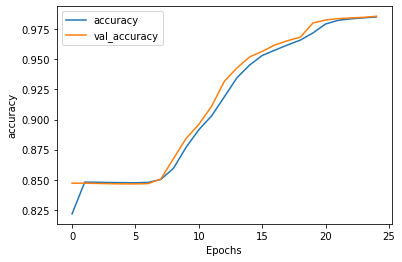

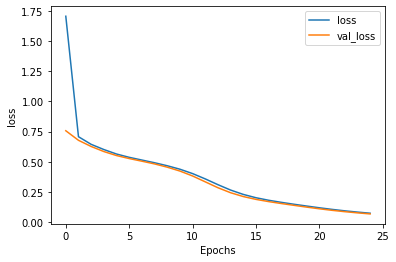

In [74]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss");

In [75]:
model1.evaluate(x_test, np.array(y_test))

78/78 [==============================] - 1s 15ms/step - loss: 0.0675 - accuracy: 0.9863


[0.06749879568815231, 0.9862838387489319]

In [76]:
# Evaluation
y_pred = model1.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

78/78 [==============================] - 1s 15ms/step


In [77]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true] 

In [78]:
print("F1-score is : {:.1%}".format(f1_score(y_test_true, y_pred)))

F1-score is : 90.9%


In [79]:
y_pred=y_pred
y_true=y_test_true
from seqeval.metrics import classification_report
report = classification_report(y_true,y_pred,suffix=True, zero_division='warn',
                          scheme=None)
print(report)

              precision    recall  f1-score   support

           B       0.96      0.70      0.81      3895
           I       0.89      0.87      0.88      8370
           _       0.95      0.94      0.94      6576

   micro avg       0.92      0.86      0.89     18841
   macro avg       0.93      0.84      0.88     18841
weighted avg       0.93      0.86      0.89     18841



In [80]:
y_pred=y_pred
y_true=y_test_true
from seqeval.metrics import classification_report
report = classification_report(y_true,y_pred,suffix=True, zero_division='warn',
                          scheme=None)
print(report)

              precision    recall  f1-score   support

           B       0.96      0.70      0.81      3895
           I       0.89      0.87      0.88      8370
           _       0.95      0.94      0.94      6576

   micro avg       0.92      0.86      0.89     18841
   macro avg       0.93      0.84      0.88     18841
weighted avg       0.93      0.86      0.89     18841



In [81]:
new_classes= list(idx2tag.values())
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
m = MultiLabelBinarizer().fit(y_true)
print(classification_report(m.transform(y_true), m.transform(y_pred),target_names=list(m.classes_)))

              precision    recall  f1-score   support

  B-callsign       0.97      0.84      0.90      1493
   B-direct1       0.00      0.00      0.00         4
B-frequency1       0.00      0.00      0.00       301
  B-heading1       0.96      1.00      0.98       921
    B-level1       0.85      0.18      0.30       453
    B-level2       0.00      0.00      0.00         3
    B-speed1       0.00      0.00      0.00       139
  B-traffic1       0.00      0.00      0.00        69
  I-callsign       1.00      1.00      1.00      2432
   I-direct1       0.00      0.00      0.00         5
I-frequency1       0.89      0.99      0.94      1057
  I-heading1       0.84      0.99      0.91       816
    I-level1       0.97      0.99      0.98       969
    I-speed1       1.00      0.09      0.16       303
  I-traffic1       0.00      0.00      0.00         1
  I-traffic2       0.00      0.00      0.00        67
           o       1.00      1.00      1.00      2473

   micro avg       0.96   

In [82]:
i = np.random.randint(0, x_test.shape[0])
p = model1.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print('{:15}{:15}\t {}\n'.format('Word', 'True', 'Pred'))
print('-'*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
    print('{:15}{}\t{}'.format(words[w-1], idx2tag[true], idx2tag[pred]))

1/1 [==============================] - 0s 26ms/step
Word           True           	 Pred

------------------------------
tuffo          B-callsign	B-callsign
nantucket      I-callsign	I-callsign
control        I-callsign	I-callsign
atis           I-callsign	I-callsign
would          I-callsign	I-callsign
gave           o	o
country        o	o
expect         o	o
comply         B-level1	I-frequency1
max            I-heading1	I-heading1
sure           o	o
nav            o	o
checkmate      B-level1	I-frequency1
sight          o	o
would          I-callsign	I-callsign
turn           o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing          o	o
doing         

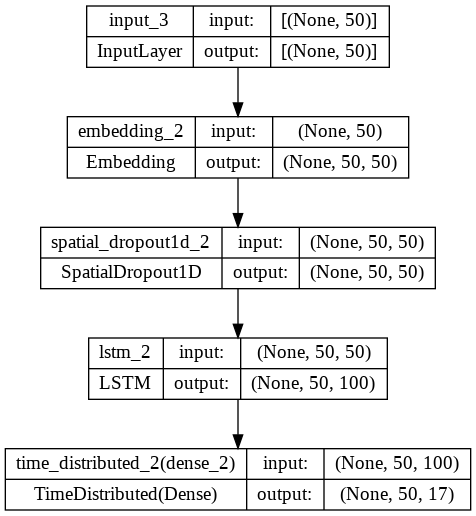

In [83]:
from keras.utils import plot_model
plot_model(model1,'Lstm.png',show_shapes= True)

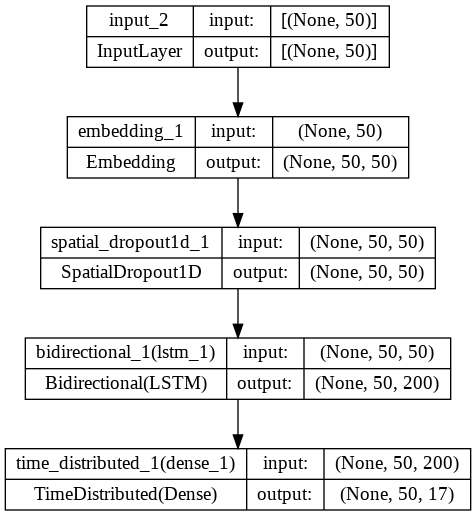

In [84]:
plot_model(model,'Bi-Lstm.png',show_shapes= True)

In [85]:
import re
import string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [86]:
test_sentence="blue ridge six sixty nine i see you're requesting flight level one eight zero amend altitude maintain flight level one eight zero"
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in tokenize(test_sentence)]],
                            padding="post", value=0, maxlen=max_len)

In [87]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(tokenize(test_sentence), p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))

1/1 [==============================] - 0s 41ms/step
Word           ||Prediction
blue           : B-callsign
ridge          : B-callsign
six            : I-callsign
sixty          : I-callsign
nine           : I-callsign
i              : o    
see            : o    
you            : o    
'              : o    
re             : o    
requesting     : o    
flight         : I-level1
level          : B-level1
one            : o    
eight          : o    
zero           : I-callsign
amend          : B-level1
altitude       : I-level1
maintain       : I-level1
flight         : I-level1
level          : I-speed1
one            : o    
eight          : o    
zero           : I-callsign
